# **Анализ сервиса вопросов и ответов по программированию**

<u>**Схема базы данных:**</u>

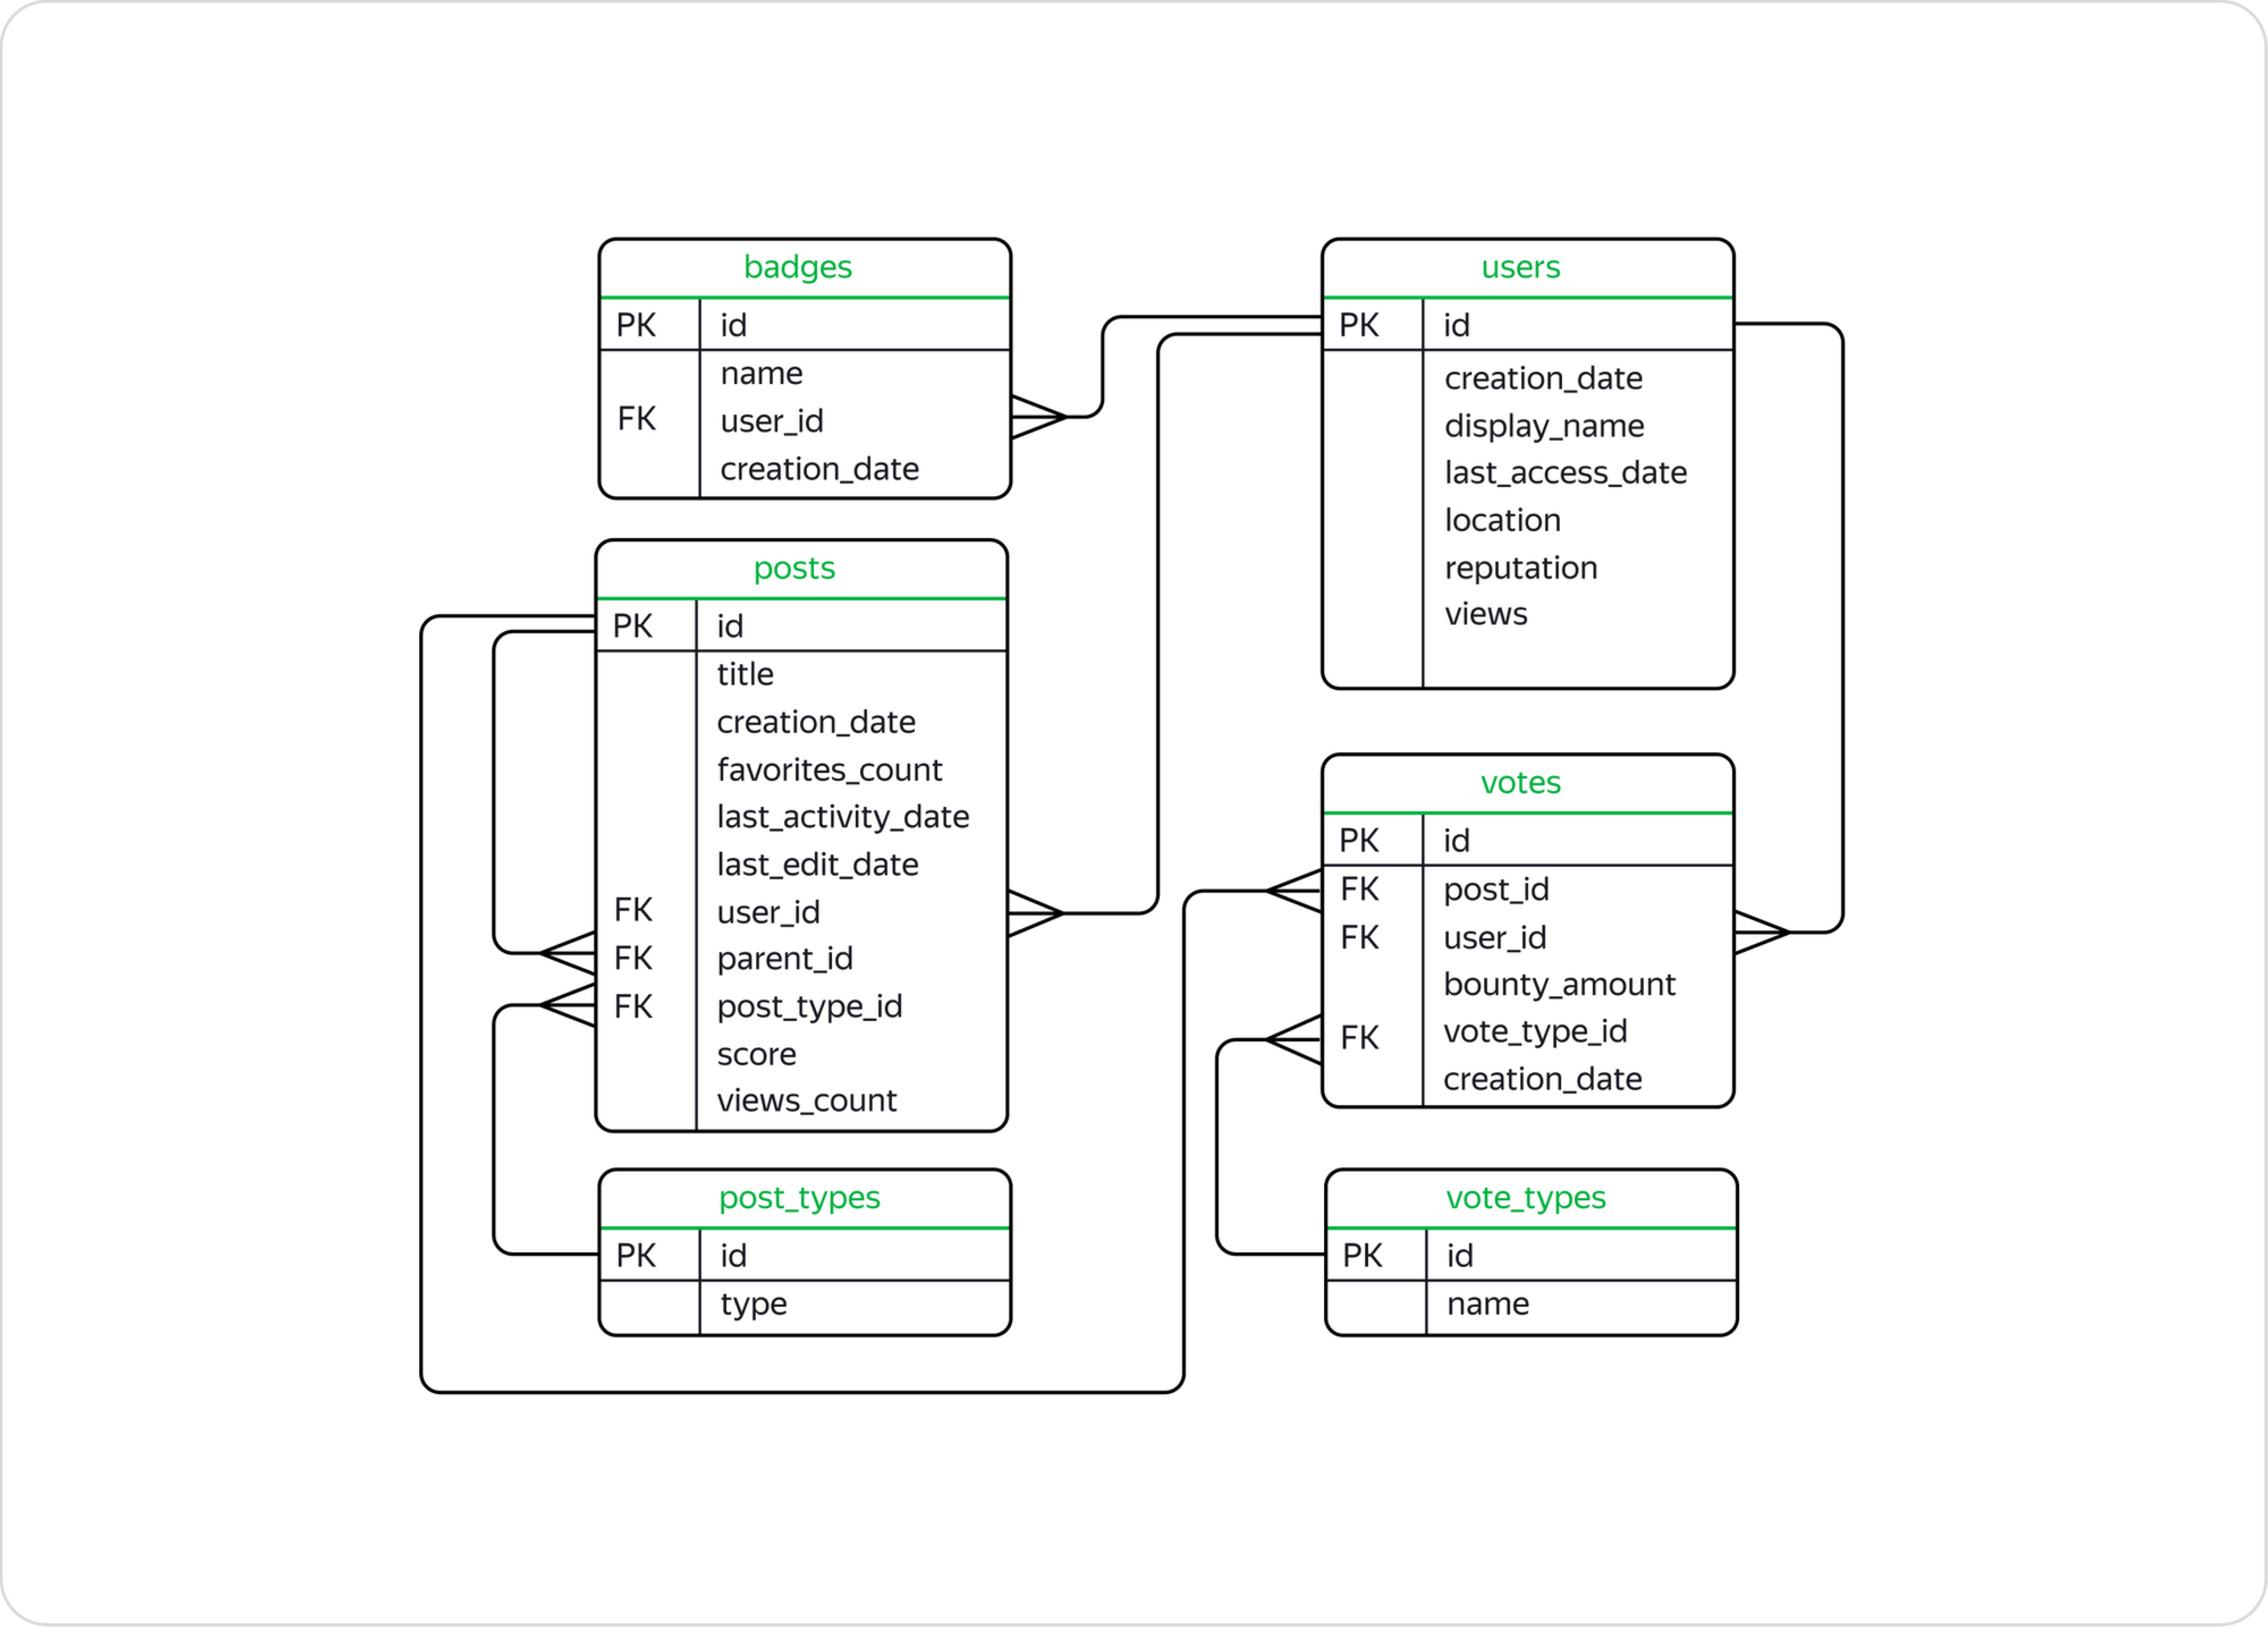

<u>**Расчеты:**</u>


## Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки»

```SQL
SELECT count(p.id)
FROM stackoverflow.posts AS p
LEFT JOIN stackoverflow.post_types AS t ON p.post_type_id = t.id
WHERE t.type = 'Question'
  AND (score > 300
       OR favorites_count >= 100);
```

## Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа

```SQL
SELECT round(avg(COUNT))
FROM
  (SELECT creation_date::date AS date_q,
          count(p.id)
   FROM stackoverflow.posts AS p
   LEFT JOIN stackoverflow.post_types AS t ON p.post_type_id = t.id
   WHERE t.type = 'Question'
     AND creation_date::date BETWEEN '2008-11-01' AND '2008-11-18'
   GROUP BY 1) AS aa;
```

## Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей

```SQL
SELECT count(DISTINCT user_id)
FROM stackoverflow.badges AS b
LEFT JOIN stackoverflow.users AS u ON b.user_id = u.id
WHERE b.creation_date::date = u.creation_date::date;
```

## Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

```SQL
SELECT count(DISTINCT p.id)
FROM stackoverflow.posts AS p
RIGHT JOIN stackoverflow.votes AS v ON v.post_id = p.id
LEFT JOIN stackoverflow.users AS u ON u.id = p.user_id
WHERE display_name = 'Joel Coehoorn';
```

## Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id


```SQL
SELECT *,
       ROW_NUMBER() OVER (
                          ORDER BY id DESC) AS rank
FROM stackoverflow.vote_types
ORDER BY rank DESC;
```

## Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя

```SQL
SELECT v.user_id,
       count(v.id)
FROM stackoverflow.votes AS v
LEFT JOIN stackoverflow.vote_types AS t ON t.id = v.vote_type_id
WHERE t.name = 'Close'
GROUP BY 1
ORDER BY 2 DESC,
         1 DESC
LIMIT 10;
```

## Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно. Отобразите несколько полей:  идентификатор пользователя; число значков; место в рейтинге — чем больше значков, тем выше рейтинг. Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге. Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя

```SQL
SELECT user_id,
       count(id),
       dense_rank() over(
                         ORDER BY count(id) DESC)
FROM stackoverflow.badges
WHERE creation_date::date BETWEEN '2008-11-15' AND '2008-12-15'
GROUP BY user_id
ORDER BY 2 DESC,
         1
LIMIT 10;
```

## Сколько в среднем очков получает пост каждого пользователя? Сформируйте таблицу из следующих полей: заголовок поста; идентификатор пользователя; число очков поста; среднее число очков пользователя за пост, округлённое до целого числа. Не учитывайте посты без заголовка, а также те, что набрали ноль очков

```SQL
SELECT title,
       user_id,
       score,
       round(avg(score) over(PARTITION BY user_id))
FROM stackoverflow.posts
WHERE title != ''
  AND score != 0;
```

## Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список

```SQL
WITH user_post AS
  (SELECT user_id,
          count(id)
   FROM stackoverflow.badges
   GROUP BY user_id
   HAVING count(id) > 1000)
SELECT title
FROM stackoverflow.posts
WHERE title != ''
  AND user_id in
    (SELECT user_id
     FROM user_post);
```

## Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей: пользователям с числом просмотров больше либо равным 350 присвойте группу 1; пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2; пользователям с числом просмотров меньше 100 — группу 3. Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу

```SQL
SELECT id,
       VIEWS,
       CASE
           WHEN VIEWS >= 350 THEN 1
           WHEN VIEWS >= 100
                AND VIEWS < 350 THEN 2
           WHEN VIEWS < 100 THEN 3
       END
FROM stackoverflow.users
WHERE LOCATION like '%United States%'
  AND VIEWS != 0;
```

## Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора

```SQL
SELECT DISTINCT id,
                CASE
                    WHEN VIEWS>=350 THEN 1
                    WHEN VIEWS>=100 THEN 2
                    ELSE 3
                END cat,
                VIEWS
FROM stackoverflow.users
WHERE VIEWS IN
    (SELECT max(VIEWS) mv
     FROM
       (SELECT id,
               VIEWS,
               CASE
                   WHEN VIEWS>=350 THEN 1
                   WHEN VIEWS>=100 THEN 2
                   ELSE 3
               END cat
        FROM stackoverflow.users
        WHERE VIEWS!=0
          AND LOCATION like '%United States%') q1
     GROUP BY cat)
  AND LOCATION like '%United States%'
ORDER BY 3 DESC,
         1;
```

## Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями: номер дня; число пользователей, зарегистрированных в этот день; сумму пользователей с накоплением

```SQL
WITH cr AS
  (SELECT creation_date::date AS dt,
          count(id) AS count_id
   FROM stackoverflow.users
   WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-30'
   GROUP BY 1)
SELECT row_number() over(),
                    count_id,
                    sum(count_id) over(
                                       ORDER BY dt)
FROM cr;
```

## Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите: идентификатор пользователя; разницу во времени между регистрацией и первым постом

```SQL
WITH uu AS
  (SELECT DISTINCT u.id
   FROM stackoverflow.users AS u
   RIGHT JOIN stackoverflow.posts AS p ON p.user_id=u.id),
     aa AS
  (SELECT u.id,
          p.creation_date - u.creation_date AS dt
   FROM stackoverflow.users AS u
   RIGHT JOIN stackoverflow.posts AS p ON p.user_id=u.id)
SELECT uu.id,
       min(aa.dt)
FROM uu
LEFT JOIN aa ON aa.id = uu.id
GROUP BY uu.id;
```

## Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров

```SQL
SELECT date_trunc('month', creation_date)::date AS month_date,
       sum(views_count)
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 DESC;
```

## Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке

```SQL
SELECT display_name as name_us,
       COUNT(distinct u.id)
FROM stackoverflow.users u 
JOIN stackoverflow.posts p ON u.id = p.user_id
JOIN stackoverflow.post_types pt ON pt.id= p.post_type_id
 
WHERE pt.type = 'Answer' AND (date_trunc('day', p.creation_date) >= date_trunc('day', u.creation_date) and                       date_trunc('day', p.creation_date) <= date_trunc('day', u.creation_date) + interval '1 month')
 
GROUP BY  name_us
HAVING count(p.id)>100
order by 1;
```

## Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию

```SQL
SELECT date_trunc('month', creation_date)::date,
       count(id)
FROM stackoverflow.posts
WHERE user_id in
    (SELECT DISTINCT u.id
     FROM stackoverflow.users AS u
     RIGHT JOIN stackoverflow.posts AS p ON p.user_id = u.id
     WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31'
       AND u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30')
GROUP BY 1
ORDER BY 1 DESC;
```

## Используя данные о постах, выведите несколько полей: идентификатор пользователя, который написал пост; дата создания поста; количество просмотров у текущего поста; сумму просмотров постов автора с накоплением. Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста

```SQL
SELECT user_id,
       creation_date,
       views_count,
       sum(views_count) OVER (PARTITION BY user_id
                              ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY 1,
         2;
```

## Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат

```SQL
WITH cc AS
  (WITH uu AS
     (SELECT DISTINCT u.id AS u_id,
                      p.creation_date::date AS date_cr
      FROM stackoverflow.users AS u
      RIGHT JOIN stackoverflow.posts AS p ON u.id = p.user_id
      WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-07') SELECT u_id,
                                                                                count(date_cr) AS c_p
   FROM uu
   GROUP BY 1)
SELECT round(avg(c_p))
FROM cc;
```

## На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями: номер месяца; количество постов за месяц; процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим. Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой. Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип numeric

```SQL
SELECT EXTRACT(MONTH
               FROM creation_date) AS MONTH,
       COUNT(id) AS post_cnt,
       ROUND(((COUNT(id)::numeric / lag(COUNT(id)) OVER (
                                                         ORDER BY EXTRACT(MONTH
                                                                          FROM creation_date)))) * 100.0 - 100, 2) AS month_diff
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY MONTH;
```

## Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде: номер недели; дата и время последнего поста, опубликованного на этой неделе

```SQL
SELECT DISTINCT extract(WEEK
                        FROM creation_date),
                max(creation_date) OVER (PARTITION BY extract(WEEK
                                                              FROM creation_date))
FROM stackoverflow.posts
WHERE user_id in
    (SELECT user_id
     FROM
       (SELECT user_id,
               count(id)
        FROM stackoverflow.posts
        GROUP BY user_id
        ORDER BY 2 DESC
        LIMIT 1) AS aa)
  AND creation_date::date BETWEEN '2008-10-01' AND '2008-10-31';
```